In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.preprocessing.image import load_img 
from tensorflow.keras.preprocessing.image import array_to_img
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt


data=np.load('images.npy',allow_pickle=True)

#sample data
print(data[10][1])

C:\Users\vin\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\vin\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\vin\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\vin\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type

[{'label': ['Face'], 'notes': '', 'points': [{'x': 0.48, 'y': 0.10385756676557864}, {'x': 0.7716666666666666, 'y': 0.6795252225519288}], 'imageWidth': 600, 'imageHeight': 337}]


In [2]:
#initialize image height, image width with value: 224

IMAGE_HEIGHT=224
IMAGE_WIDTH=224

#Create features and labels
masks = np.zeros((int(data.shape[0]), 28,28))

X = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

#display sample train image
X_train = X[0:400]
y_train = masks[0:400]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


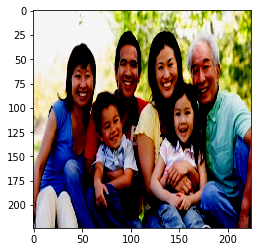

In [3]:
X_test = X[400:]
y_test = masks[400:] 
#display sample train image      
img=X_train[4]
plt.imshow(img)
plt.show()  

In [4]:
#show the image as array
from PIL import Image
from numpy import asarray
imgarray=asarray(img)
print(imgarray)

[[[ 0.96078432  0.96078432  0.96078432]
  [ 0.96078432  0.96078432  0.96078432]
  [ 0.96078432  0.96078432  0.96078432]
  ...
  [ 0.59215689  0.68627453 -0.08235294]
  [ 0.49019611  0.57647061 -0.17647058]
  [ 0.51372552  0.60784316 -0.13725489]]

 [[ 0.96078432  0.96078432  0.96078432]
  [ 0.96078432  0.96078432  0.96078432]
  [ 0.96078432  0.96078432  0.96078432]
  ...
  [ 0.65490198  0.74117649 -0.01960784]
  [ 0.54509807  0.63921571 -0.14509803]
  [ 0.47450984  0.56862748 -0.23921567]]

 [[ 0.96078432  0.96078432  0.96078432]
  [ 0.96078432  0.96078432  0.96078432]
  [ 0.96078432  0.96078432  0.96078432]
  ...
  [ 0.7647059   0.82745099  0.05098045]
  [ 0.58431375  0.67058825 -0.18431371]
  [ 0.34117651  0.45098042 -0.48235291]]

 ...

 [[ 0.34117651  0.34117651  0.41960788]
  [ 0.52941179  0.52941179  0.60784316]
  [ 0.28627455  0.28627455  0.34901965]
  ...
  [ 0.14509809 -0.10588235 -0.09803921]
  [-0.69411767 -0.62352943 -0.4588235 ]
  [-0.89019608 -0.74117649 -0.47450978]]

 [

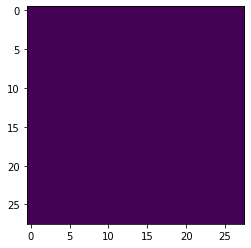

In [5]:
#display sample mask
plt.imshow(y_train[4])

In [6]:
from tensorflow.keras.layers import Reshape, UpSampling2D, Concatenate, Conv2D
from tensorflow.keras.layers import MaxPooling2D,Conv2DTranspose
from tensorflow.keras.models import Model
#create model
def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=1.0, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable
           

    block1 = model.get_layer("conv_pw_5_relu").output
    block2 = model.get_layer("conv_pw_11_relu").output
    block3 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block3), block2])
    x = Concatenate()([UpSampling2D()(x), block1])

    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((28, 28))(x)

    return Model(inputs=model.input, outputs=x)

#Create the model and print summary
model = create_model(False)
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0

In [8]:
#Define dice coefficient
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return numerator / (denominator + tf.keras.backend.epsilon())

    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())
#Define loss function
def loss(y_true, y_pred):
     return binary_crossentropy(y_true, y_pred) - tf.keras.backend.log(dice_coefficient(y_true, y_pred) + tf.keras.backend.epsilon())


from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy

optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#compile model
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

#callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("model-{val_loss:.2f}.h5", monitor="val_loss", verbose=1, save_best_only=True, save_weights_only=True)

stop = EarlyStopping(monitor="val_loss", patience=5)

reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1)


#fit model
model.fit(X_train, y_train,validation_data=(X_test,y_test), epochs=1, batch_size=32, verbose=1)

Train on 399 samples, validate on 9 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
399/399 [==============================] - 87s 219ms/sample - loss: 4.7462 - dice_coefficient: 0.0387 - val_loss: 16.6644 - val_dice_coefficient: 0.0000e+00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


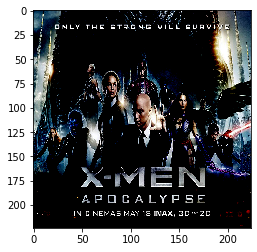

In [9]:
#show the test image 
test_img=X_test[8]
plt.imshow(test_img)

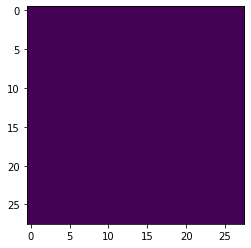

In [10]:
#show the original mask
plt.imshow(y_test[8])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


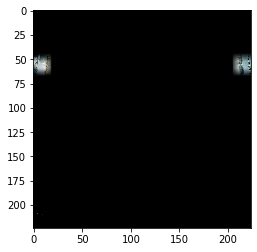

In [11]:
image = cv2.resize(test_img, (IMAGE_WIDTH, IMAGE_HEIGHT))
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

test_image=plt.imshow(feat_scaled)
pred_mask = cv2.resize(1.0*(model.predict(x=np.array([feat_scaled]))[0] > 0.5), (IMAGE_WIDTH,IMAGE_HEIGHT))
plt.imshow(pred_mask)
image2 = image
image2[:,:,0] = pred_mask*image[:,:,0]
image2[:,:,1] = pred_mask*image[:,:,1]
image2[:,:,2] = pred_mask*image[:,:,2]

out_image = image2
#predict mask on test image 
plt.imshow(out_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


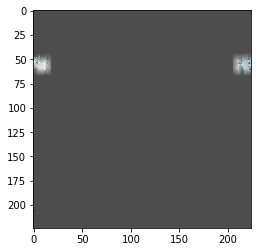

In [12]:
#Impose the mask on the test image with alpha >0.5
plt.imshow(out_image,alpha=0.7)